In [1]:
import numpy as np
import tensorflow.compat.v1 as tf1
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as ds

import vmm
from vmm import tf_robotic_toolbox as tk

from IPython.core import display
import matplotlib.pyplot as plt

%matplotlib inline
# %load_ext autoreload 
# %autoreload 2

In [3]:
sess = tf1.InteractiveSession()
tf1.disable_eager_execution()

# Create robot kinematics

In [4]:
robot = tk.BimanualThreeJointRobot()

/home/pignate/code/pbdlib/public/pbdlib/vmm/vmm/tf_robotic_toolbox/utils/plot_utils.py:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')
/home/pignate/code/pbdlib/public/pbdlib/vmm/vmm/tf_robotic_toolbox/utils/plot_utils.py:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


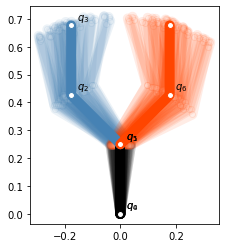

In [5]:
tk.utils.plot_robots(
    robot, 
    np.random.multivariate_normal([np.pi/2., np.pi/4, -np.pi/4, -np.pi/4, np.pi/4], 0.1 ** 2 * np.eye(5), (50, )),
    alpha=0.1, color='steelblue', bicolor='orangered', text=False,
);
tk.utils.plot_robots(
    robot, 
    [[np.pi/2., np.pi/4, -np.pi/4, -np.pi/4, np.pi/4]],
    alpha=1.0, color='steelblue', bicolor='orangered'
);

## Define PoE model 

In [5]:
# Define experts distribution parameters
parameters = {
    'os_0_loc' : tf1.placeholder(tf.float32, (2,)),
    'os_1_loc' : tf1.placeholder(tf.float32, (2, )),
    'os_std' : tf1.placeholder(tf.float32, ()),
}

In [6]:
# Define joint limit cost
lambda_cost = tf1.placeholder(tf.float32, ()) # multiplier of joint limit cost
std_limits = tf1.placeholder(tf.float32, ())  # std deviation of joint limits normal distribution (safety margin)
                            # joint limits are implemented with normal distribution and CDF 

def joint_limit_cost(q):
    return lambda_cost * tf.reduce_sum(robot.joint_limit_cost(q, std_limits), -1)

In [7]:
fs = [
    lambda q : robot.xs(q, concat=False)[0][:, -1, :],
    lambda q : robot.xs(q, concat=False)[1][:, -1, :]
]

In [8]:
@tf.custom_gradient
def f1_proj(q):
    return vmm.utils.tf.nullspace_project(fs[1], fs[0], q)


In [9]:
################################
# create PoE
model = vmm.PoE((5,),
    # specify p_j
    experts=[
        ds.MultivariateNormalDiag(
            parameters['os_0_loc'], 
            parameters['os_std'] * tf.ones((2, )), 
        ), 
        ds.MultivariateNormalDiag(
            parameters['os_1_loc'], 
            parameters['os_std'] * tf.ones((2, )), 
        )
    ],
    # specify f_j
    transfs=[
        fs[0],
        # fs[1]
        f1_proj,
    ], cost=joint_limit_cost)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Variational GMM to approximate PoE

In [10]:
# create approximation
approx = vmm.approx.GMMApprox(
    model._log_unnormalized_prob, ndim=5,
    loc=[np.pi/2., 0., 0., 0., 0.], std=1.5, temp=1., 
                         cov_type='full', k=25, samples=5, loc_tril=0.01)

# retrieve approximate variational distribution q
q = approx.gmm

In [11]:
# create samples from q to display
n_samples_gmm = tf1.placeholder(tf.int32, ())
q_samples = approx.gmm.sample(n_samples_gmm)

# compute fk of samples from q
xs_samples = robot.xs(q_samples)

In [12]:
rate = tf1.placeholder(tf.float32, ())
optimizer = tf1.train.AdamOptimizer(rate)
cost = approx.cost
train = optimizer.minimize(cost, var_list=approx.opt_params)
train_wo_priors = optimizer.minimize(cost, var_list=approx.opt_params[1:]) # train without prior

In [13]:
init = tf1.global_variables_initializer()

### Optimize ELBO 

In [18]:
# feed parameters
#### Incompatible task
feed_dict = {
    lambda_cost: 0.0001,
    std_limits: 0.01,
    parameters['os_0_loc']: [0.4, 0.4],
    parameters['os_1_loc']: [-0.7, 0.],
    parameters['os_std']: 0.02,
}
#### Compatible task

feed_dict = {
    lambda_cost: 0.0001,
    std_limits: 0.01,
    parameters['os_0_loc']: [0.2, 0.4],
    parameters['os_1_loc']: [-0.2, 0.4],
    parameters['os_std']: 0.02,
}

In [15]:
sess.run(init)

In [19]:
## press twice "i" key to interrupt
for i in range(2000):
    try:
        train_priors = i > 1000
        feed_dict[rate] = 0.005 if i < 500 else 0.001
        
        if not i % 10:
            display.clear_output(wait=True)
            _cost_approx = sess.run(cost, feed_dict)    
            print("ELBO %.2f" % _cost_approx)
            if train_priors:
                print("Optimizing priors")
                
        if train_priors:
            sess.run(train, feed_dict)    
        else:
            sess.run(train_wo_priors, feed_dict)    
    
    except KeyboardInterrupt:
        break

ELBO -2.99


### Display samples 

/home/pignate/publication/publications/VMM/code/vmm/vmm/tf_robotic_toolbox/utils/plot_utils.py:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


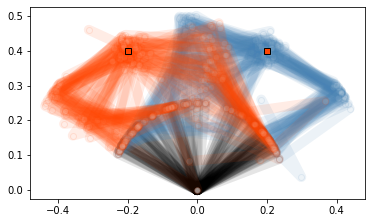

In [20]:
_q_samples = q_samples.eval({n_samples_gmm: 100})

_targets = sess.run([parameters['os_0_loc'], parameters['os_1_loc']], feed_dict=feed_dict)
tk.utils.plot_robots(
    robot, 
    _q_samples,
    alpha=0.1, color='steelblue', bicolor='orangered', text=False,
);
for i in range(2):
     plt.plot(_targets[i][0], _targets[i][1], 'ks', color='orangered', mec='k')